# Flower Classification

**Exploracion de datos y Preprocesamiento**

**Yalila Aljure Jimenez**

email: yalila.aljure@udea.edu.co

CC. 5288540



**IMPORTING LIBRARIES**

In [ ]:
import tensorflow as tf
tf.__version__

'2.6.0'

In [ ]:
import keras
keras.__version__

'2.6.0'

In [ ]:
import sklearn
sklearn.__version__

'0.22.2.post1'

In [ ]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import PIL
import pathlib
from mpl_toolkits.axes_grid1 import ImageGrid
from matplotlib import pyplot as plt
import random
import math 
from sklearn.metrics import roc_curve, auc, multilabel_confusion_matrix, plot_confusion_matrix, roc_auc_score
from keras.layers import Conv2D, Dropout, MaxPooling2D, BatchNormalization, Activation, Flatten, Dense, InputLayer, Input,AvgPool2D, GlobalAveragePooling2D, concatenate,MaxPool2D, ReLU
from tensorflow.keras import regularizers, optimizers
from keras.models import Sequential, Model
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
import tensorflow.keras.backend as K

**LOAD DATA**

In [ ]:
!wget https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz

--2021-10-28 16:22:46--  https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.125.128, 142.250.157.128, 142.251.8.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.125.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228813984 (218M) [application/x-compressed-tar]
Saving to: ‘flower_photos.tgz’

flower_photos.tgz   100%[===================>] 218.21M   122MB/s    in 1.8s    

2021-10-28 16:22:48 (122 MB/s) - ‘flower_photos.tgz’ saved [228813984/228813984]



In [ ]:
# Unzipping Data
!gunzip flower_photos.tgz

In [ ]:
!tar -xvf flower_photos.tar

**Plotting Images**

In [ ]:
data_dir = pathlib.Path('flower_photos')
folder = list(data_dir.glob('*'))
images = list(data_dir.glob('*/*.jpg')) #list of all images (full path)

In [ ]:
len(images) # Number of images

3670

In [ ]:
fig = plt.figure(figsize=(20, 20))
iterable = np.array(random.sample(range(1, 3670), 54)) # Choosing 54 random images
for i in range(54):
    plt.subplot(9, 6, i+1)
    j = iterable[i]
    plt.title(str(images[j]).split('/')[-1], fontsize=10) # file name and disply as title
    plt.imshow(PIL.Image.open(images[j])) # Displaying Image
    ax = plt.axis("off")

Output hidden; open in https://colab.research.google.com to view.

**Parameters**

In [ ]:
image_size = 224 # Setting the size of the images
b_size = 32

**Imagen Preprocessing**

Data Augmantation

Original source is not partitioned. The test set will be fixed at 20% of the entire dataset. The rest of the dataset will be used for training (0.8) and validation (0.2).

In [ ]:
idg_flip = tf.keras.preprocessing.image.ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest',
    validation_split = 0.2
)

In [ ]:
flower_gen_train = idg_flip.flow_from_directory(data_dir,
                                    target_size=(image_size, image_size),
                                    batch_size=b_size,
                                    subset='training',
                                    class_mode='categorical',
                                    shuffle=True,
                                    seed=123
                                    )

Found 2939 images belonging to 5 classes.


In [ ]:
flower_gen_test = idg_flip.flow_from_directory(data_dir,
                                    target_size=(image_size, image_size),
                                    batch_size=b_size,
                                    subset='validation',
                                    class_mode='categorical',
                                    shuffle=True,
                                    seed=123
                                    )

Found 731 images belonging to 5 classes.


**DenseNet 121**

In [ ]:
def densenet(input_shape, n_classes, filters = 32):

  def bn_rl_conv(x,filters,kernel=1,strides=1):    
        x = BatchNormalization()(x)
        x = ReLU()(x)
        x = Conv2D(filters, kernel, strides=strides,padding = 'same')(x)
        return x

  def dense_block(x, repetition):   
        for _ in range(repetition):
            y = bn_rl_conv(x, 4*filters)
            y = bn_rl_conv(y, filters, 3)
            x = concatenate([y,x])
        return x

  def transition_layer(x):    
        x = bn_rl_conv(x, K.int_shape(x)[-1] //2 )
        x = AvgPool2D(2, strides = 2, padding = 'same')(x)
        return x

  input = Input (input_shape)
  x = Conv2D(64, 7, strides = 2, padding = 'same')(input)
  x = MaxPool2D(3, strides = 2, padding = 'same')(x)
    
  for repetition in [6,12,24,16]:     
        d = dense_block(x, repetition)
        x = transition_layer(d)

  x = GlobalAveragePooling2D()(d)
  output = Dense(n_classes, activation = 'softmax')(x)
    
  model = Model(input, output)
  return model

In [ ]:
input_shape = image_size,image_size,3
n_classes = 5

In [ ]:
model = densenet(input_shape,n_classes,b_size)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 112, 112, 64) 9472        input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 56, 56, 64)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 56, 56, 64)   256         max_pooling2d[0][0]              
______________________________________________________________________________________________

In [ ]:
model.compile(optimizer='SGD', loss='categorical_crossentropy', metrics=['accuracy','Precision','Recall'])

In [ ]:
Result = model.fit(flower_gen_train, validation_data=flower_gen_test
                   , epochs=100, verbose=1, shuffle=True)

Epoch 1/100
92/92 [==============================] - 132s 947ms/step - loss: 1.2815 - accuracy: 0.4668 - precision: 0.6044 - recall: 0.2137 - val_loss: 1.6821 - val_accuracy: 0.2449 - val_precision: 1.0000 - val_recall: 0.0096
Epoch 2/100
92/92 [==============================] - 80s 872ms/step - loss: 1.0929 - accuracy: 0.5641 - precision: 0.6697 - recall: 0.3947 - val_loss: 1.8020 - val_accuracy: 0.2490 - val_precision: 0.2571 - val_recall: 0.2367
Epoch 3/100
92/92 [==============================] - 80s 869ms/step - loss: 1.0452 - accuracy: 0.5890 - precision: 0.6834 - recall: 0.4406 - val_loss: 1.6784 - val_accuracy: 0.3434 - val_precision: 0.3939 - val_recall: 0.2818
Epoch 4/100
92/92 [==============================] - 80s 868ms/step - loss: 0.9997 - accuracy: 0.6138 - precision: 0.7041 - recall: 0.4849 - val_loss: 1.3591 - val_accuracy: 0.4337 - val_precision: 0.4840 - val_recall: 0.3311
Epoch 5/100
92/92 [==============================] - 80s 868ms/step - loss: 0.8789 - accuracy: 

In [ ]:
mpl.rcParams.update({'font.size': 10, 'font.family': 'STIXGeneral', 'mathtext.fontset': 'stix'})

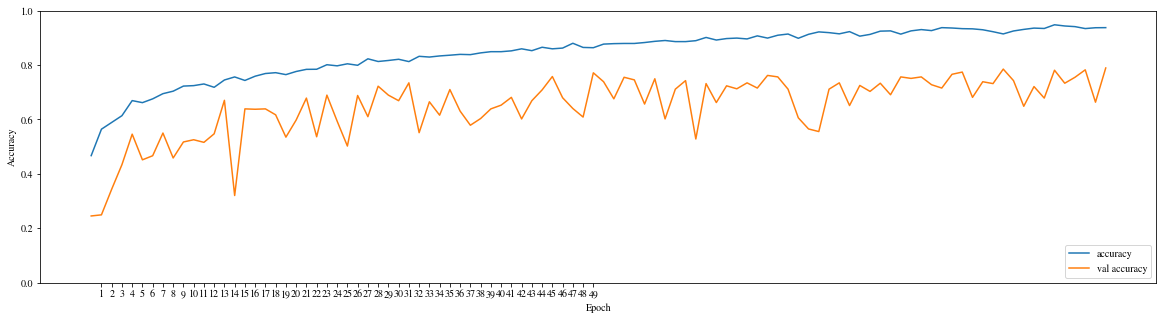

In [ ]:
plt.figure(figsize=(20,5))
plt.plot(Result.history['accuracy'], label='accuracy')
plt.plot(Result.history['val_accuracy'], label='val accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xticks(list(range(1,50)))
plt.ylim([0, 1])
plt.legend(loc='lower right')


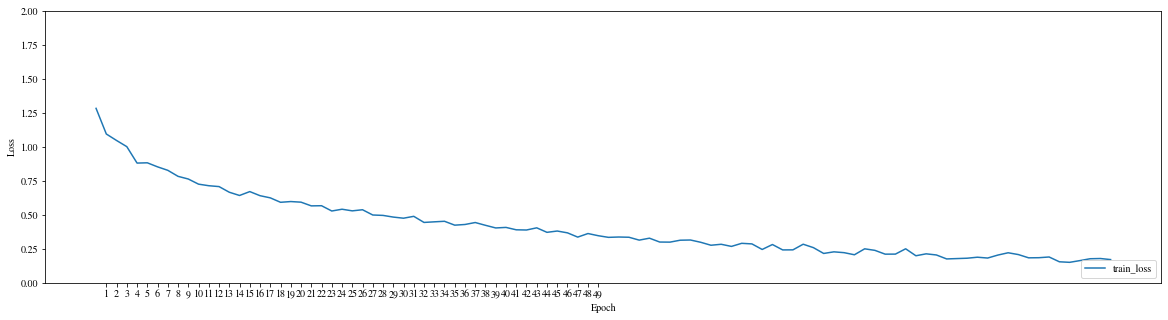

In [ ]:
plt.figure(figsize=(20,5))
plt.plot(Result.history['loss'], label='train_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(list(range(1,50)))
plt.ylim([0, 2])
plt.legend(loc='lower right')

In [ ]:
flower_gen_test.reset()
x_test, y_test = next(flower_gen_test)
for i in tqdm(range(int(len(flower_gen_test.labels)/b_size))):
  img, label = next(flower_gen_test)
  x_test = np.append(x_test, img, axis = 0)
  y_test = np.append(y_test, label, axis = 0)

print(x_test.shape,y_test.shape)


100%|██████████| 22/22 [00:10<00:00,  2.09it/s]

(731, 224, 224, 3) (731, 5)


In [ ]:
#plt.figure(figsize=(10,5))
y_pred = model.predict(x_test)
#y_pred = model.predict(x_test).ravel()
#fpr, tpr, thresholds = roc_curve(y_test.ravel(), y_pred)
auc_keras = roc_auc_score(y_test,y_pred,multi_class='ovr')
print("ROC AUC score OVR:" + str(auc_keras))
#plt.title("ROC AUC score:" + str(auc_keras))
#plt.plot(y_test,y_pred, marker = ".")
auc_keras = roc_auc_score(y_test,y_pred,multi_class='ovo')
print("ROC AUC score OVO:" + str(auc_keras))

ROC AUC score OVR:0.9377761335601956
ROC AUC score OVO:0.9377761335601956


The higher the AUC, the better performance of the model at distinguishing between the positives and negatives classes

**Final Scores**

Accuracy = $\frac{(TP+TN)}{(TP+FP+TN+FN)}$

Precision = $\frac{TP}{(TP+FP)}$

Recall =$\frac{TP}{(TP+FN)}$

In [ ]:
y_pred = model.predict(x_test)
y_pred=np.argmax(y_pred, axis=1)
y_test=np.argmax(y_test, axis=1)

In [ ]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [ ]:
flower_labels = flower_gen_train.class_indices.keys()
print(flower_labels)

dict_keys(['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips'])


Normalized confusion matrix
[[0.78571429 0.0952381  0.07936508 0.00793651 0.03174603]
 [0.02793296 0.8603352  0.05027933 0.05027933 0.01117318]
 [0.046875   0.0703125  0.640625   0.046875   0.1953125 ]
 [0.05035971 0.13669065 0.05035971 0.74100719 0.02158273]
 [0.03773585 0.10062893 0.20125786 0.04402516 0.6163522 ]]


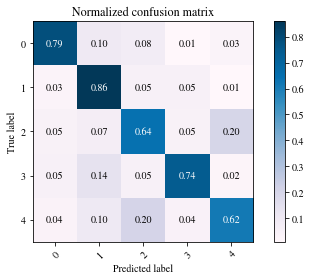

In [ ]:
plot_confusion_matrix(y_test, y_pred, classes=np.r_[0,1,2,3,4], normalize=True, cmap=plt.cm.PuBu)

**Plot Evaluation**

In [ ]:
model.save("07_model.h5")

In [ ]:
def plot_example(X, y, y_pred=None):
# Create figure with 3 x 3 sub-plots.
  fig, axes = plt.subplots(3, 6)
  fig.set_size_inches(18,10)
  fig.subplots_adjust(hspace=0.3, wspace=0.3)
  X, y = X[:18, ..., 0], y[:18]
  for i, ax in enumerate(axes.flat):
    # Plot image.
    ax.imshow(X[i], alpha = 1)
    # Show true and predicted classes.
    if y_pred is None:
      xlabel = "True: {0}".format(y[i])
    else:
      xlabel = "True: {0}, Pred: {1}".format(y[i], y_pred[i])
    # Show the classes as the label on the x-axis.
    ax.set_xlabel(xlabel)
    # Remove ticks from the plot.
    ax.set_xticks([])
    ax.set_yticks([])
    # Ensure the plot is shown correctly with multiple plots in a single Notebook cell.
  plt.show()

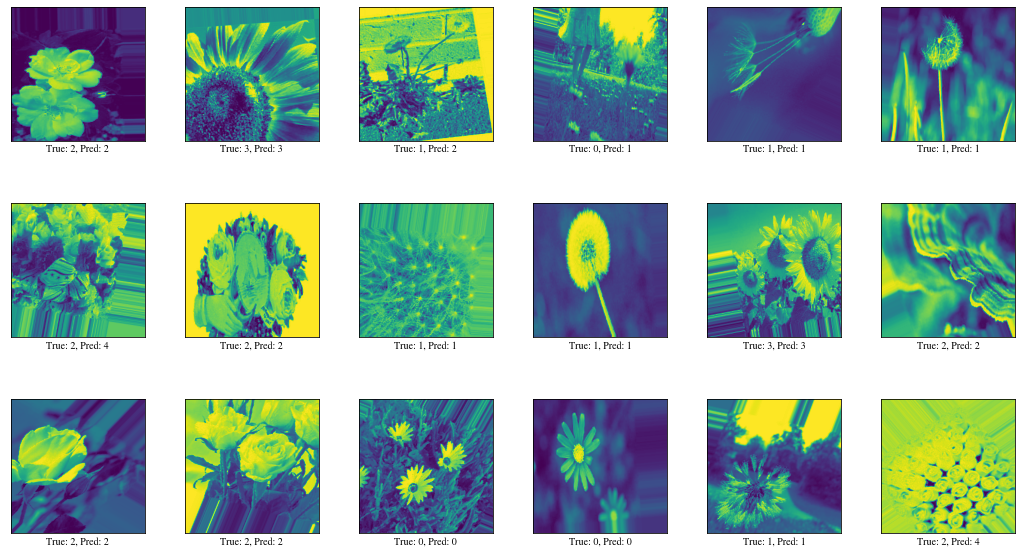

In [ ]:
model = tf.keras.models.load_model('07_model.h5')
#%matplotlib inline
# Make prediction
predictions = model.predict(x_test)
# retrieve prediction indices
pred_y = np.argmax(predictions, axis=1)
# Plot some examples with model predictions
plot_example(x_test, y_test, y_pred)